# Nick's Modeling

In [6]:
import os
import pathlib
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)

In [92]:
import pandas as pd
import numpy as np
import datetime

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot
import matplotlib.pylab as plt 
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

rs = 109

In [58]:
country_names = ['United States']

state_names = ["Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", 
               "Connecticut", "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", 
               "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", 
               "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi",
               "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey",
               "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
               "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas",
               "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", 
               "West Virginia", "Wyoming"]

city_names = ['Ann Arbor', 'Annapolis', 'Atlanta', 'Austin', 'Bakersfield', 'Baltimore', 'Birmingham - Alabama',
             'Boston', 'Bridgeport', 'Charlotte', 'Cincinnati', 'Cleveland', 'Colorado Spring', 'Columbus',
             'Corpus Christi', 'Dallas', 'Denver', 'Detroit', 'Fresno', 'Grand Rapids', 'Greensboro',
             'Hartford', 'Honolulu', 'Houston', 'Indianapolis', 'Jacksonville', 'Kansas City', 'Las Vegas',
             'Lexington', 'Los Angeles', 'Louisville', 'Madison', 'Memphis', 'Miami', 'Milwaukee', 
             'Minneapolis', 'Modesto', 'Monterey', 'Nashville', 'New Haven', 'New Orleans', 'New York City',
             'Oklahoma City', 'Omaha', 'Orlando', 'Philadelphia', 'Phoenix', 'Pittsburgh', 'Portland', 'Providence',
             'Raleigh', 'Richmond', 'Rochester', 'Sacramento', 'Saint Petersburg - Clearwater (Florida)', 'Salt Lake City',
             'San Antonio', 'San Diego', 'San Francisco - Bay Area', 'Santa Barbara', 'Seattle', 'Spokane', 'St. Louis',
             'Tacoma', 'Tampa', 'Tucson', 'Tulsa', 'Ventura', 'Virginia Beach', 'Washington DC']

us_locations = country_names + state_names + city_names
apple_mobility = pd.read_csv('data/applemobilitytrends-2020-04-26.csv') # will need to change this
apple_countries = apple_mobility[apple_mobility['geo_type'] == 'country/region']
apple_us = apple_mobility[apple_mobility['region'].isin(us_locations)]

In [22]:
google_mobility = pd.read_csv('data/Global_Mobility_Report.csv', dtype={'sub_region_1': 'object', 'sub_region_2': 'object'})
google_us = google_mobility[google_mobility['country_region_code'] == 'US']

Text(0, 0.5, 'Percentage Mobility')

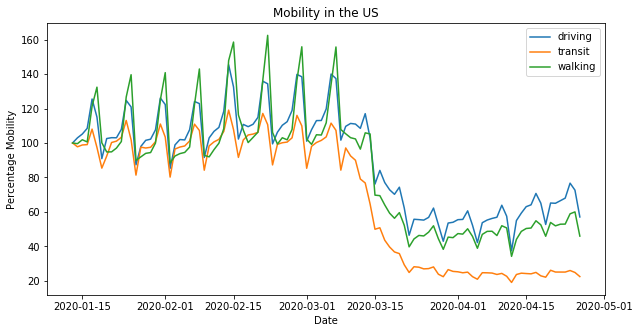

In [53]:
trans_type = ['driving', 'transit', 'walking']
apple_us_total = apple_us[apple_us['region'] == 'United States']
num_days = len(apple_us_total.columns[4:])
base = datetime.datetime(2020, 1, 13)
date_list = [base + datetime.timedelta(days=x) for x in range(num_days)]

plt.figure(0, figsize=(10,5))
for i in range(3):
    y = apple_us_total.values[i][4:]
    plt.plot(date_list, y, label=trans_type[i])
plt.legend()
plt.title('Mobility in the US')
plt.xlabel('Date')
plt.ylabel('Percentage Mobility')

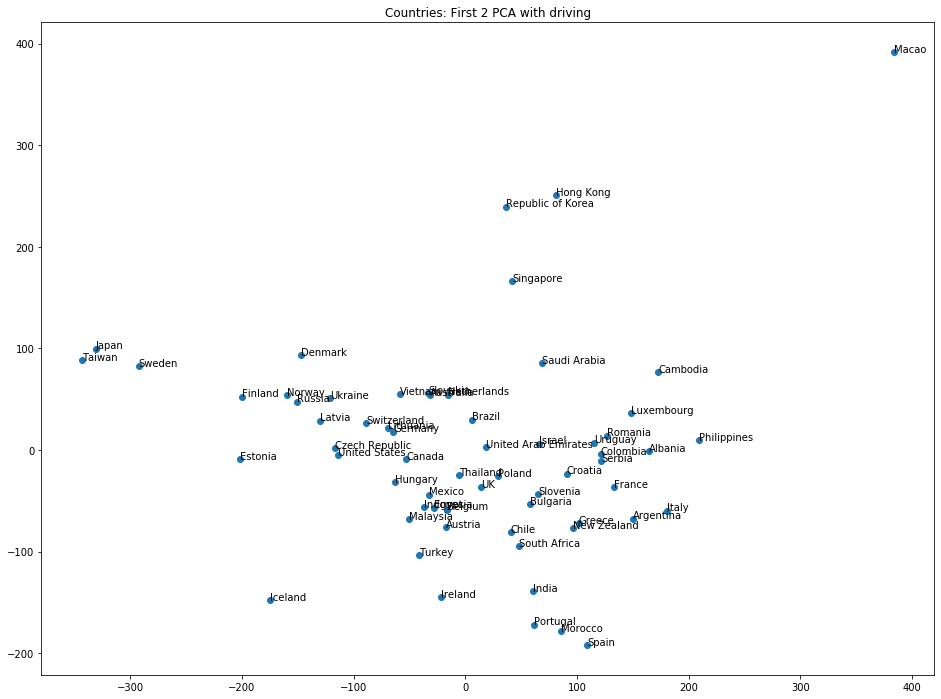

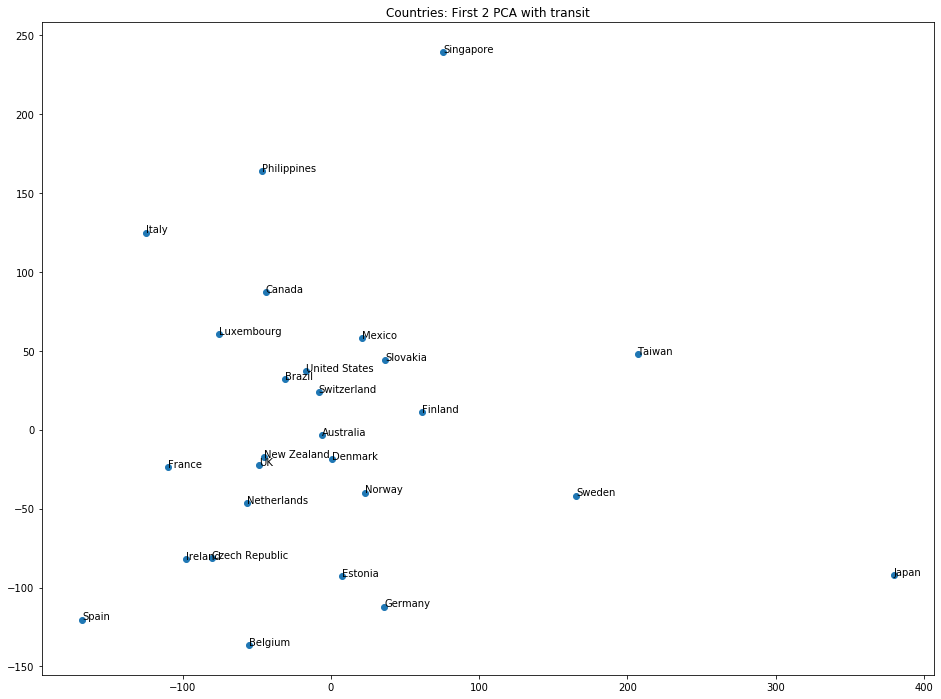

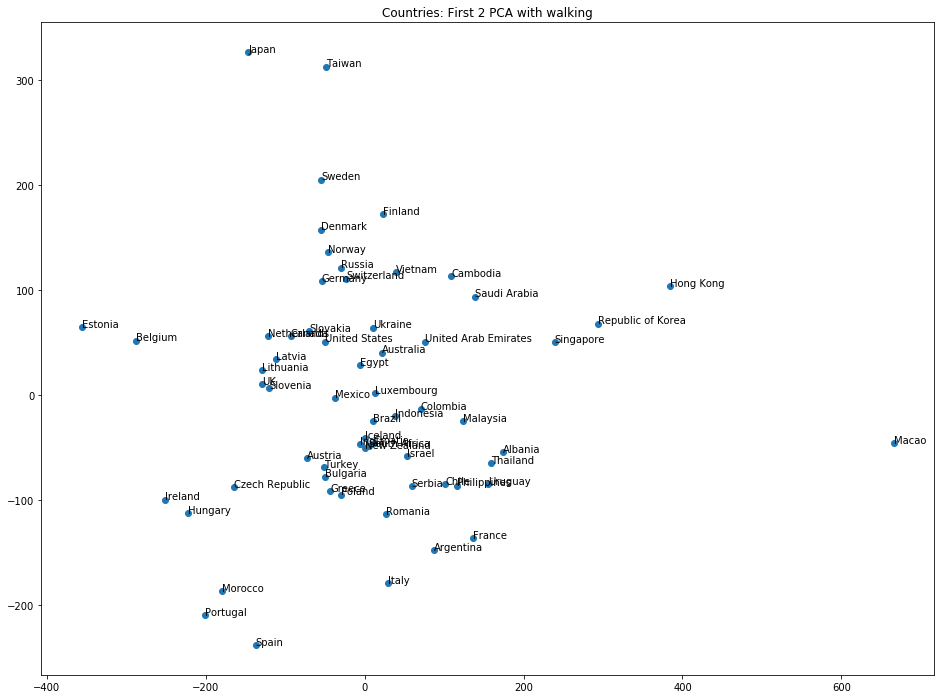

In [97]:
trans_type = ['driving', 'transit', 'walking']
apple_countries_idx = apple_countries.set_index('region').drop(columns=['geo_type', 'alternative_name'])

apple_countries_drive = apple_countries_idx[apple_countries_idx['transportation_type'] == 'driving'].drop(columns='transportation_type')

trans_pcas = []
trans_pcas_countries = []

for t in trans_type:
    pca = PCA(n_components=2)
    apple_countries_type = apple_countries_idx[apple_countries_idx['transportation_type'] == t].drop(columns='transportation_type')
    countries_pca = pca.fit_transform(apple_countries_type)
    trans_pcas.append(countries_pca)
    x = countries_pca.T[0]
    y = countries_pca.T[1]
    fig, ax = plt.subplots(figsize=(16,12))
    ax.scatter(x,y)
    ax.set_title('Countries: First 2 PCA with ' + t)
    trans_pcas_countries.append(apple_countries_type.index)
    for i, txt in enumerate(apple_countries_type.index):
        ax.annotate(txt, (x[i], y[i]))

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


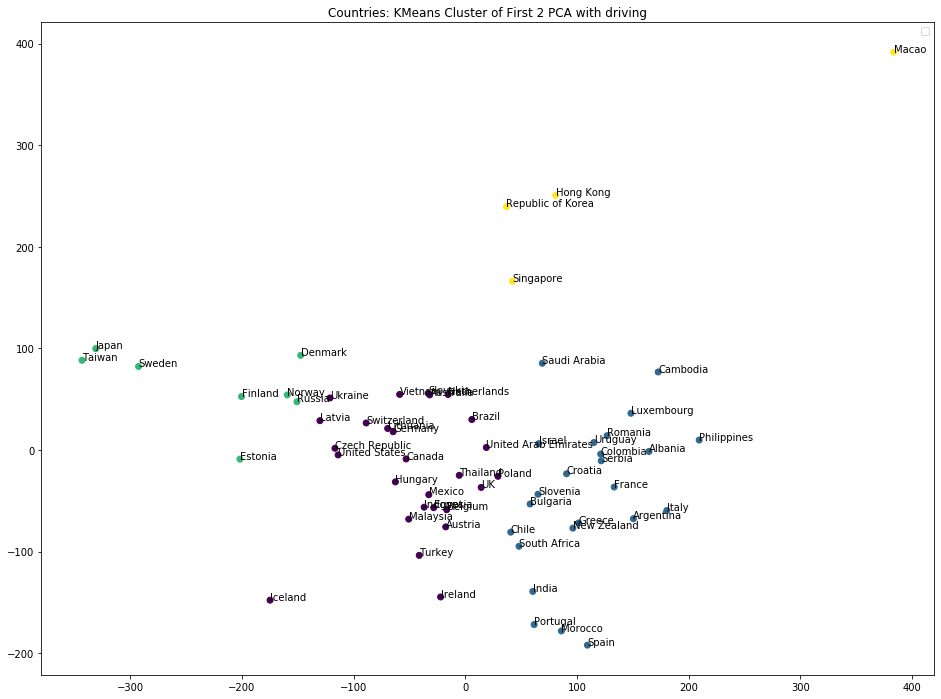

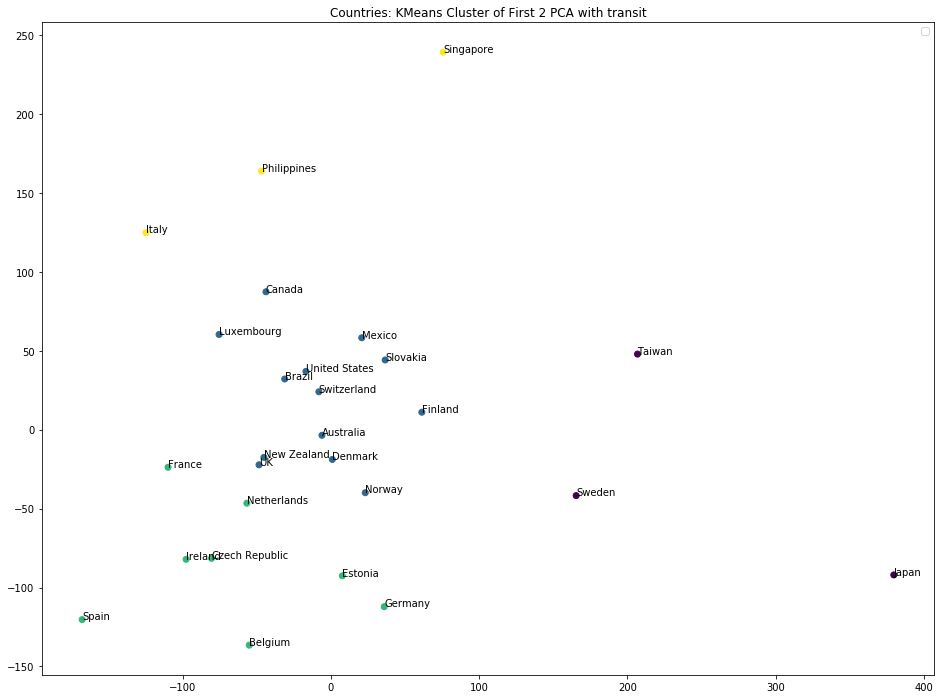

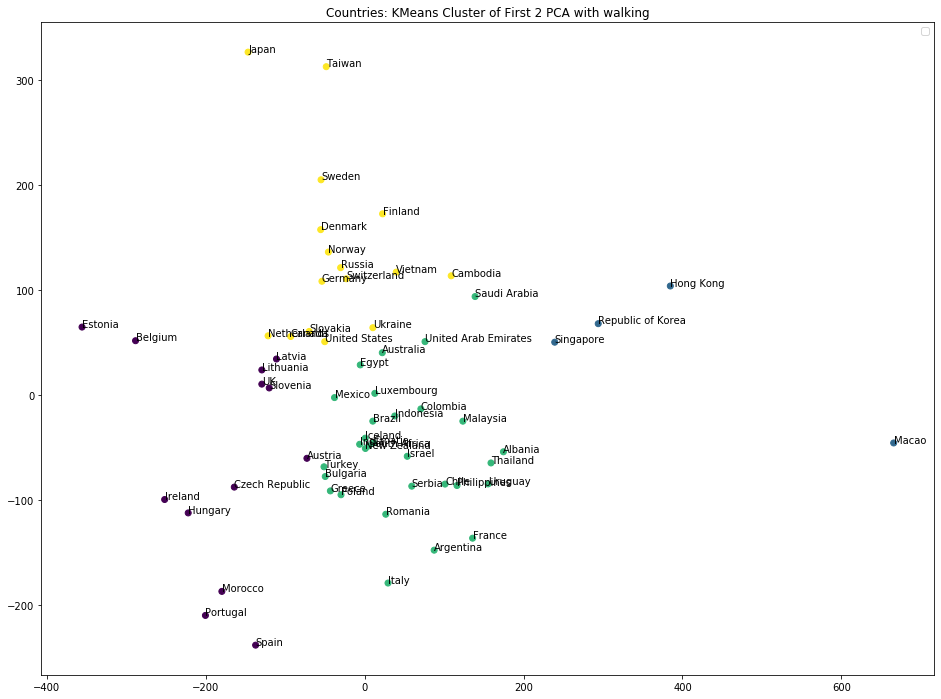

In [101]:
for i in range(3):
    km = KMeans(n_clusters=4, random_state=rs).fit(trans_pcas[i])
    x = trans_pcas[i].T[0]
    y = trans_pcas[i].T[1]
    fig, ax = plt.subplots(figsize=(16,12))
    ax.scatter(x, y, c=km.predict(trans_pcas[i]))
    ax.set_title('Countries: KMeans Cluster of First 2 PCA with ' + str(trans_type[i]))
    for i, txt in enumerate(trans_pcas_countries[i]):
        ax.annotate(txt, (x[i], y[i]))